In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import scipy.interpolate
from scipy.ndimage import gaussian_filter
import tifffile
import seaborn as sns

from IPython.display import HTML
import matplotlib.animation as animation
from tqdm.notebook import tqdm, trange
from scipy.optimize import curve_fit
#import gaussian
from skimage.filters import gaussian
from scipy.interpolate import RectBivariateSpline
from PIL import Image
import itertools



In [3]:

PROJECT_PATH = 'C:/Users/amityu/DataspellProjects/gel_sheets/'
DATA_PATH = 'C:/Users/amityu/Gel_Sheet_Data/'
#movie = 'Control'
#movie = '130721'
#movie ='140721'
#movie ='150721'
#movie ='100621'
movie ='130721_CCA60_RAW'
ADD_PATH = os.path.join(PROJECT_PATH, "add_data/")


MOVIE_PATH = DATA_PATH +  movie + '/'
GRAPH_PATH = 'C:/Users/amityu/Gel_Sheet_Graph/'

In [4]:
gel = np.load(MOVIE_PATH + 'np/gel_norm.npy')

In [4]:
membrane = np.load(MOVIE_PATH + 'np/membrane.npy').astype(int)
surface = np.load(MOVIE_PATH + 'np/height.npy').astype(int)

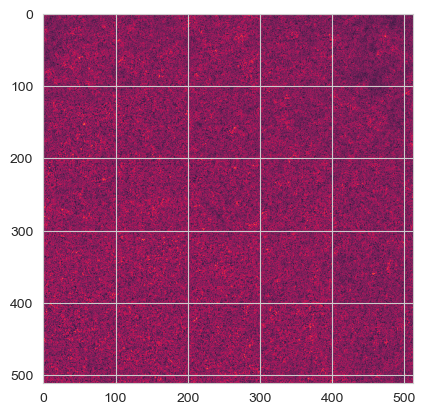

In [43]:
surface[surface>=gel.shape[1]] = gel.shape[1]-1
intensity = np.zeros(surface.shape)

for t,i,j in itertools.product(range(gel.shape[0]),range(gel.shape[2]), range(gel.shape[3])):
    intensity[t,i,j] = gel[t, membrane[t,i,j]  ,i,j]

plt.imshow(intensity[10])
plt.show()

In [44]:
#make animation for intensity with imshow and colorbar, and save it

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('Intensity')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_xlim(0, intensity.shape[2])
ax.set_ylim(0, intensity.shape[1])

im = ax.imshow(intensity[0], cmap='jet', vmin=0, vmax=np.nanmax(intensity))
fig.colorbar(im)
def animate(i):
    im.set_data(intensity[i])
    ax.set_title('Intensity at t = ' + str(i))
    return im

ani = animation.FuncAnimation(fig, animate, frames=intensity.shape[0], interval=1000, blit=False)
ani.save(GRAPH_PATH + 'correlation/plate_intensity/' +movie + 'membrane_intensity.mp4', writer='ffmpeg', fps=1)
plt.close()


In [6]:

membrane_intensity = np.zeros(membrane.shape)
surface_intensity = np.zeros(surface.shape)
for t  in range(len(gel)):
    membrane_intensity[t] = gel[t, membrane[t], np.arange(gel.shape[2]), np.arange(gel.shape[3])]
    surface_intensity[t] = gel[t, surface[t], np.arange(gel.shape[2]), np.arange(gel.shape[3])]

In [7]:
membrane_intensity = gaussian_filter(membrane_intensity, sigma=3)
surface_intensity = gaussian_filter(surface_intensity, sigma=1)

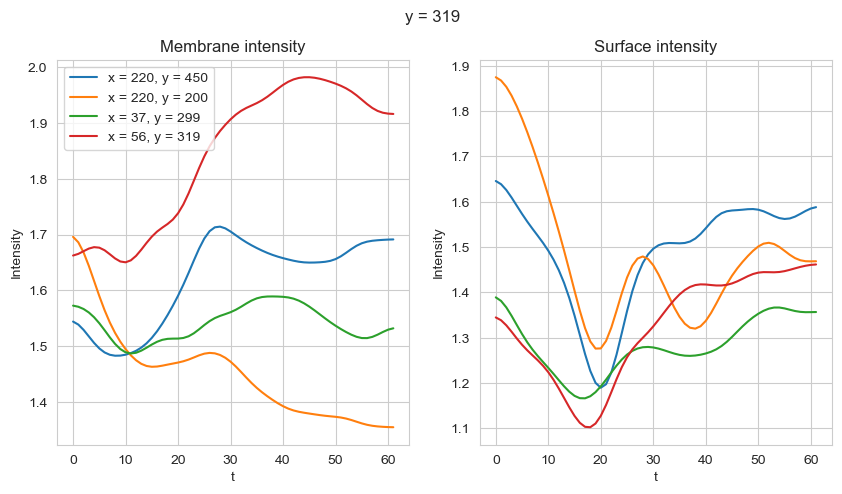

In [80]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
X= [220,220 ,37,56]
Y = [450,200,299,319]
for x,y in zip(X, Y):
    ax1.plot(membrane_intensity[:, y, x], label='x = ' + str(x) + ', y = ' + str(y))
    ax2.plot(surface_intensity[:, y, x], label='x = ' + str(x) + ', y = ' + str(y))
ax1.set_title('Membrane intensity')
ax2.set_title('Surface intensity')
ax1.set_xlabel('t')
ax2.set_xlabel('t')
ax1.set_ylabel('Intensity')
ax2.set_ylabel('Intensity')
ax1.legend()
plt.suptitle('y = ' + str(y))
plt.show()



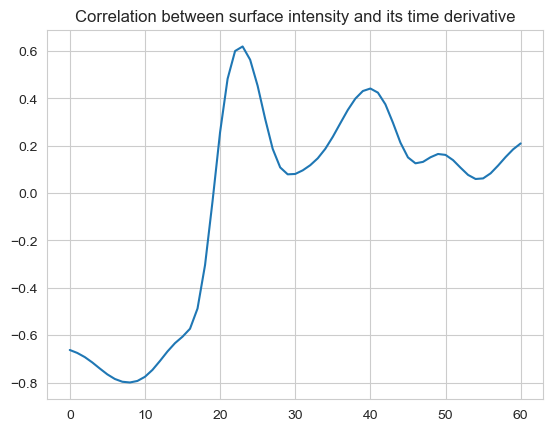

In [88]:

surface_intensity_der = surface_intensity[1:] - surface_intensity[:-1]
c = np.zeros(len(surface_intensity_der))
for t in range(len(surface_intensity_der)):
    c[t] = np.corrcoef(surface_intensity_der[t].flatten(), surface_intensity[t].flatten())[0,1]
plt.plot(c)
plt.title('Correlation between surface intensity and its time derivative')
plt.show()


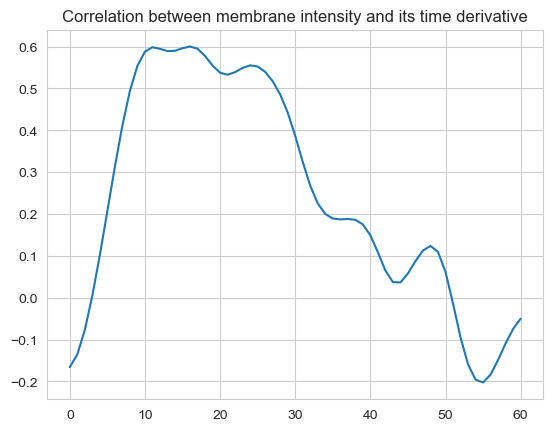

In [89]:

membrane_intensity_der = membrane_intensity[1:] - membrane_intensity[:-1]
c = np.zeros(len(surface_intensity_der))
for t in range(len(surface_intensity_der)):
    c[t] = np.corrcoef(membrane_intensity_der[t].flatten(), membrane_intensity[t].flatten())[0,1]
plt.plot(c)
plt.title('Correlation between membrane intensity and its time derivative')
plt.show()


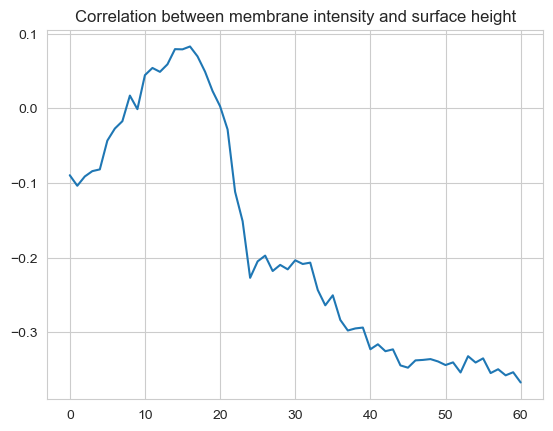

In [92]:
#correlation bettwen membrane intensity and surface
c = np.zeros(len(surface_intensity_der))
for t in range(len(surface_intensity_der)):
    c[t] = np.corrcoef(membrane_intensity[t].flatten(), surface [t].flatten())[0,1]
plt.plot(c)
plt.title('Correlation between membrane intensity and surface height')
plt.show()



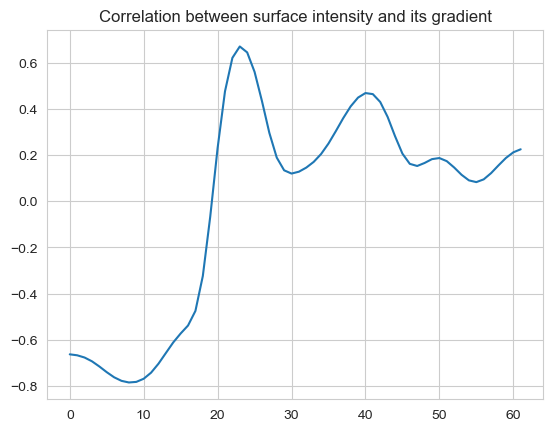

In [10]:
# correlation between surface intensity to its gradient
surface_intensity_der = np.gradient(surface_intensity, axis=0)
c = np.zeros(len(surface_intensity_der))
for t in range(len(surface_intensity_der)):
    c[t] = np.corrcoef(surface_intensity_der[t].flatten(), surface_intensity[t].flatten())[0,1]
plt.plot(c)
plt.title('Correlation between surface intensity and its gradient')
plt.show()



In [12]:
# save surface to tif file
for t in range(len(surface)):
    im = Image.fromarray(surface[t].astype(np.uint8))
    im.save(MOVIE_PATH + 'tiff/surface/' + str(t) + '.tif')

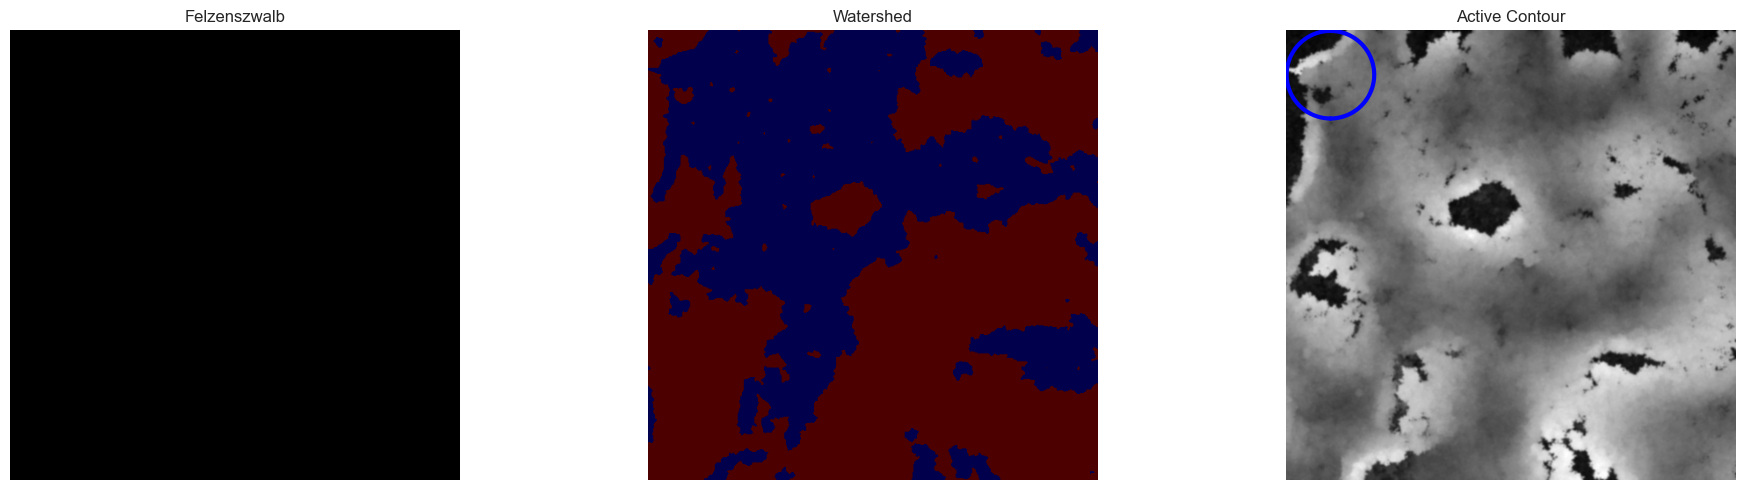

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, segmentation, filters, feature, morphology
from skimage.io import imread
from skimage.filters.rank import minimum, maximum

# Read the image

image_gray = surface[20].copy()
# Apply each segmentation function and store results
segmentations = []

# Felzenszwalb's efficient graph based segmentation
segmentations.append(('Felzenszwalb', segmentation.felzenszwalb(image)))

# Slic - KMeans based image segmentation
#segmentations.append(('SLIC', segmentation.slic(image, n_segments=250, compactness=10, sigma=1)))

# Quickshift image segmentation
#segmentations.append(('Quickshift', segmentation.quickshift(image, kernel_size=3, max_dist=6, ratio=0.5)))

# Watershed segmentation
gradient = filters.sobel(image_gray)
markers = np.zeros_like(image_gray)
foreground, background = 1, 2

# set minimum as a 2d image, and apply minimum filter on surronding pixels
selem = morphology.disk(18)


mini = filters.rank.minimum(image_gray, selem)
maxi = filters.rank.maximum(image_gray, selem)
markers[image_gray == mini]=  foreground
markers[image_gray == maxi] = background
segmentations.append(('Watershed', segmentation.watershed(gradient, markers)))

# Chan Vese segmentation
#segmentations.append(('Chan Vese', segmentation.chan_vese(image_gray, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200, dt=0.5)))

# Active Contour (Snake)
# Initialize the snake
s = np.linspace(0, 2*np.pi, 400)
init = 50*np.array([np.sin(s), np.cos(s)]).T + 50
init = np.array([init[:,1], init[:,0]]).T
snake = segmentation.active_contour(gradient, init)
segmentations.append(('Active Contour', snake))

# Display the results
fig, ax = plt.subplots(1, len(segmentations), figsize=(20, 5))
for i, (name, seg) in enumerate(segmentations):
    if name == 'Active Contour':
        ax[i].imshow(image_gray, cmap='gray')
        ax[i].plot(seg[:, 1], seg[:, 0], '-b', lw=3)
        ax[i].set_title(name)
    else:
        ax[i].imshow(color.label2rgb(seg, image=image))
        ax[i].set_title(name)
    ax[i].axis('off')
plt.tight_layout()
plt.show()


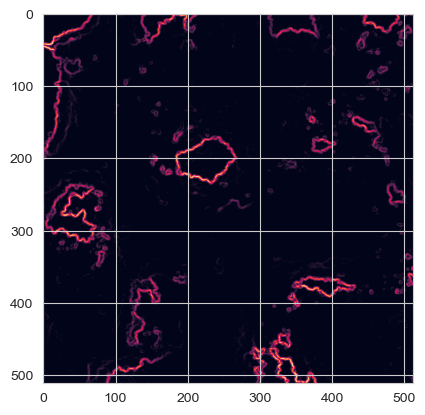

In [32]:
#apply sobel filter to surface[t]
surface_sobel = np.zeros(surface[0].shape)
t = 20
surface_sobel= filters.sobel(surface[t])
plt.imshow(surface_sobel, vmin=1*10**-9, vmax=1.7*10**-8)
plt.show()



In [39]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, color, segmentation
from skimage import graph
from skimage.segmentation import mark_boundaries

# Load a grayscale image
image = surface[19].copy()

# Use SLIC (Simple Linear Iterative Clustering) on grayscale
labels = segmentation.slic(image, compactness=30, n_segments=128*128,channel_axis=None)

# We use the original grayscale image for visualization with labels
image_segmented = color.label2rgb(labels, image, kind='avg', bg_label=0)

# Construct region adjacency graph
# Since our image is grayscale, we will compute the difference in intensity
rag = graph.rag_mean_color(image, labels, mode='distance')

# Merge regions which are similar using RAG thresholding
labels2 = graph.cut_normalized(labels, rag)
output = color.label2rgb(labels2, image, kind='avg', bg_label=0)

# Display images
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(image_segmented, cmap='gray')
ax[0].set_title('Oversegmentation with SLIC')

ax[1].imshow(output, cmap='gray')
ax[1].set_title('Segmentation with RAG Thresholding')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, io, color, feature
from skimage.morphology import clo
image = surface[21].copy()
#close holes in image (fill in the holes) with skimage

image = ndimage.binary_fill_holes(image)

plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.show()

# Sobel
sobel_edges = filters.sobel(image)

# Scharr
scharr_edges = filters.scharr(image)

# Prewitt
prewitt_edges = filters.prewitt(image)

# Canny
canny_edges = feature.canny(image, sigma=2)

# Laplacian of Gaussian (LoG)
log_edges = filters.laplace(filters.gaussian(image, sigma=2))
log_edges = np.abs(log_edges) > 0.05  # Thresholding the result to binary values

# Roberts Cross
roberts_edges = filters.roberts(image)

# Display the results
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0, 0].imshow(sobel_edges, cmap='gray')
ax[0, 0].set_title('Sobel Operator')
ax[0, 0].axis('off')

ax[0, 1].imshow(scharr_edges, cmap='gray')
ax[0, 1].set_title('Scharr Operator')
ax[0, 1].axis('off')

ax[0, 2].imshow(prewitt_edges, cmap='gray')
ax[0, 2].set_title('Prewitt Operator')
ax[0, 2].axis('off')

ax[1, 0].imshow(canny_edges, cmap='gray')
ax[1, 0].set_title('Canny Edge Detector')
ax[1, 0].axis('off')

ax[1, 1].imshow(log_edges, cmap='gray')
ax[1, 1].set_title('Laplacian of Gaussian')
ax[1, 1].axis('off')

ax[1, 2].imshow(roberts_edges, cmap='gray')
ax[1, 2].set_title('Roberts Cross Operator')
ax[1, 2].axis('off')

plt.tight_layout()
plt.show()


NameError: name 'ndimage' is not defined

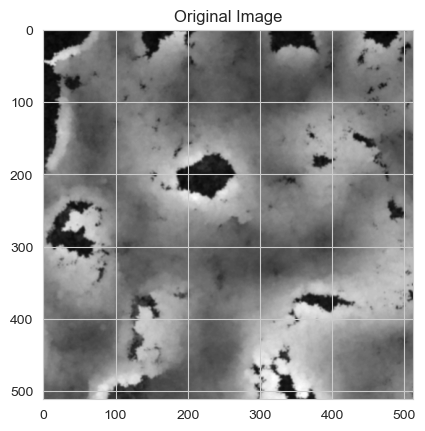

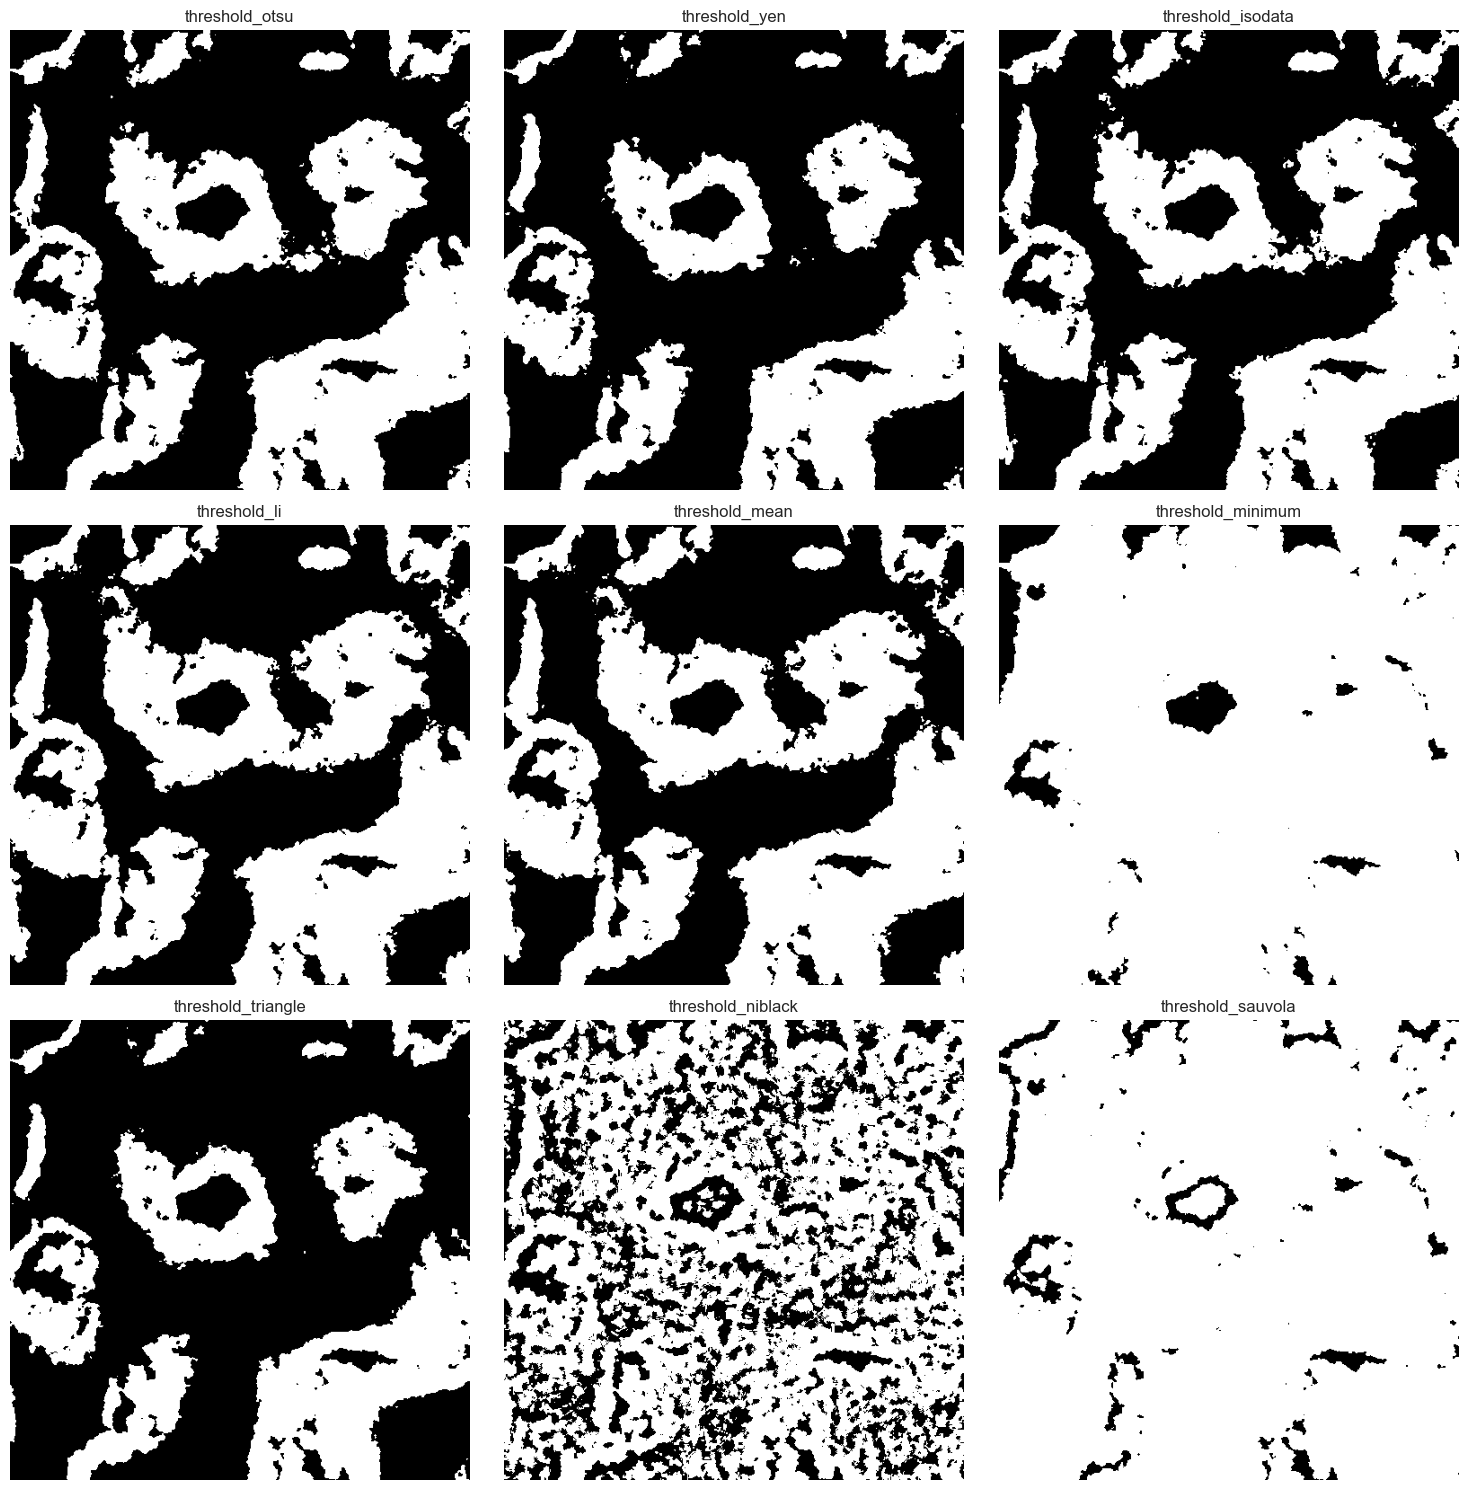

In [47]:
import matplotlib.pyplot as plt
from skimage import io, filters, color

# Load the image and ensure it's grayscale
image = surface[20].copy()
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.show()

# List of thresholding methods in skimage
methods = [
    'threshold_otsu',
    'threshold_yen',
    'threshold_isodata',
    'threshold_li',
    'threshold_mean',
    'threshold_minimum',
    'threshold_triangle',
    'threshold_niblack',
    'threshold_sauvola'
]

# Display the results
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.ravel()

for i, method_name in enumerate(methods):
    # Get the function based on its string name
    method = getattr(filters, method_name)

    # Some thresholding methods require a window size (e.g., niblack, sauvola)
    if method_name in ['threshold_niblack', 'threshold_sauvola']:
        thresh_value = method(image, window_size=25)
    else:
        thresh_value = method(image)

    # Apply the threshold
    binary = image > thresh_value

    ax[i].imshow(binary, cmap='gray')
    ax[i].set_title(method_name)
    ax[i].axis('off')

plt.tight_layout()
plt.show()


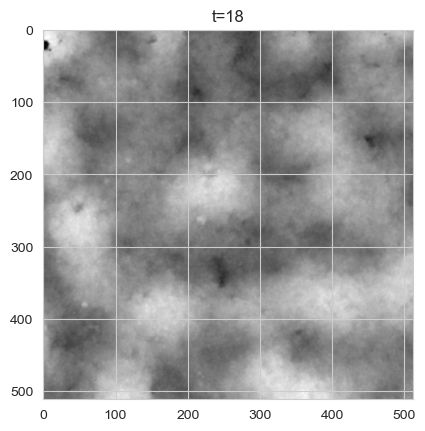

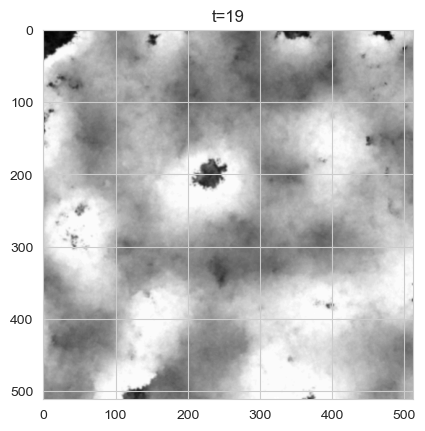

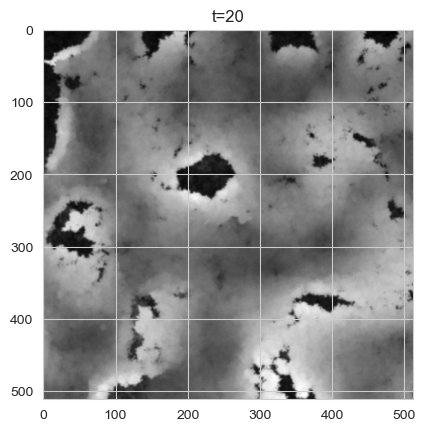

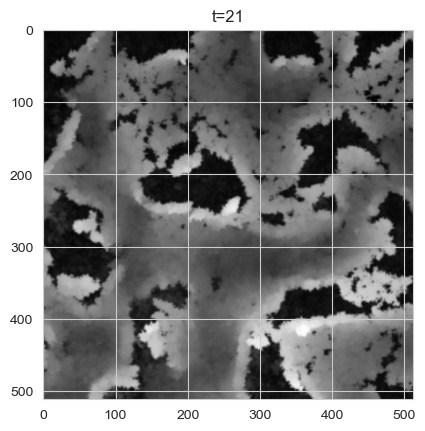

In [48]:
for t in range(18,22):
    plt.imshow(surface[t], cmap='gray')
    plt.title('t='+str(t))
    plt.show()


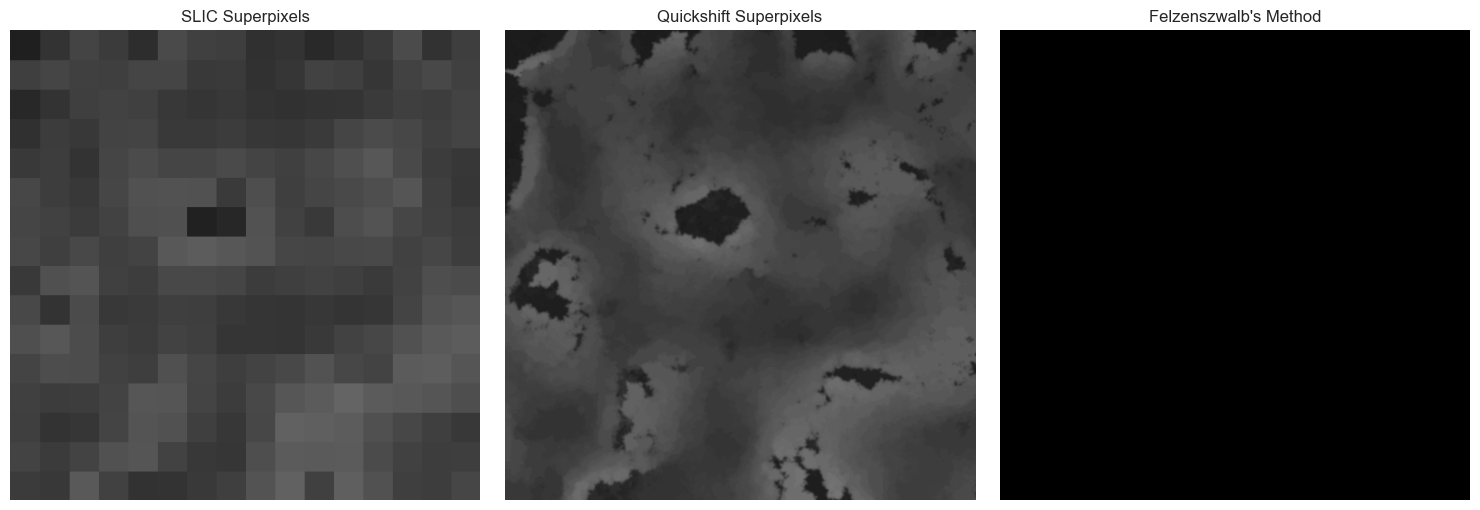

In [54]:
import matplotlib.pyplot as plt
from skimage import io, segmentation, color

image =surface[20].copy()
# SLIC superpixels
slic_segments = segmentation.slic(image, n_segments=250, compactness=10, channel_axis=None)
slic_image = color.label2rgb(slic_segments, image, kind='avg')


expanded_image= np.zeros((image.shape[0], image.shape[1], 3))
expanded_image[:,:,0] = image

quickshift_segments = segmentation.quickshift(expanded_image, ratio=0.3, max_dist=20, channel_axis=2)
quickshift_image = color.label2rgb(quickshift_segments, image, kind='avg')

# Felzenszwalb's method
felz_segments = segmentation.felzenszwalb(image, scale=100)
felz_image = color.label2rgb(felz_segments, image, kind='avg')

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(slic_image)
ax[0].set_title('SLIC Superpixels')
ax[0].axis('off')

ax[1].imshow(quickshift_image)
ax[1].set_title('Quickshift Superpixels')
ax[1].axis('off')

ax[2].imshow(felz_image)
ax[2].set_title("Felzenszwalb's Method")
ax[2].axis('off')

plt.tight_layout()
plt.show()


In [55]:
label_areas = {label: np.sum(quickshift_segments == label) for label in np.unique(quickshift_segments)}


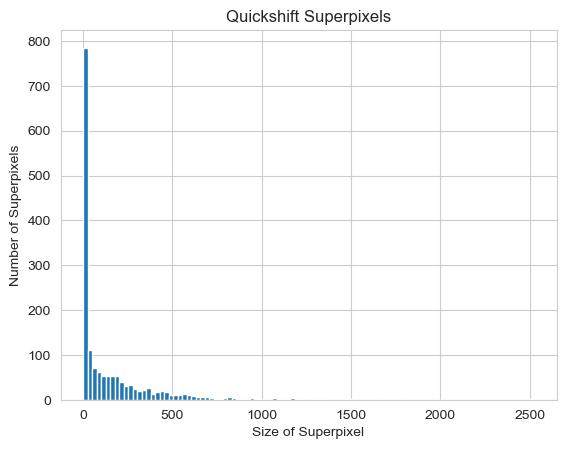

In [56]:
plt.hist(label_areas.values(), bins=100)
plt.title('Quickshift Superpixels')
plt.xlabel('Size of Superpixel')
plt.ylabel('Number of Superpixels')
plt.show()


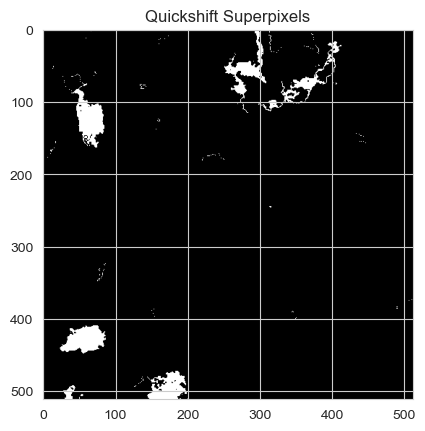

In [61]:
mask = np.zeros(image.shape)
mask[quickshift_image[:,:,0] == 51] = 1
plt.imshow(mask, cmap='gray')
plt.title('Quickshift Superpixels')
plt.show()


In [43]:
#import gaussian from skimage.filters
from skimage.filters import gaussian
surface = np.load(MOVIE_PATH+'np/height.npy')
smoothed_surface = np.zeros_like(surface)
thresh1 = 1; thresh2 =1;
spike = np.zeros_like(surface)
for t  in range(len(surface)):
    smoothed_surface[t] = gaussian(surface[t].astype(float), sigma=2)
for t in range(2,len(surface)):
    a = smoothed_surface[t].copy()
    b = smoothed_surface[t-1].copy()
    c = smoothed_surface[t-2].copy()
    #spike[t-2][np.bitwise_and((b-a)>thresh1, (c-a)>thresh2)] =60
    #spike[t-1][np.bitwise_and((b-a)>thresh1, (c-a)>thresh2)] =80

    spike[t][np.bitwise_and((b-a)>thresh1, (c-a)>thresh2)] =120

np.save(MOVIE_PATH+'np/spike.npy', spike)


In [46]:
gel = np.load(MOVIE_PATH+'np/gel.npy')

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
from matplotlib.widgets import Button
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
from scipy.ndimage import gaussian_filter
mpl.use('TkAgg')

gel_corrected = gel
surface = spike


# Create a dummy 3D numpy array as an example
# Replace this with your actual "surface" array
plot_sigma = 0
# Initialize t, y coordinates
global y,t
t = 0
y = 0

# Function to update the plot
def update_plot():
    global y,t

    h = surface[t]

    ax1.clear()
    ax2.clear()
    img = gel_corrected[t,:,y,:]
    ax1.imshow(img,origin='lower', cmap='coolwarm')
    ax1.set_xlabel('X (Pixels)')
    ax1.set_ylabel('Z (Pixels)')
    ax1.set_title('Gel Corrected by illumination filter \n y=%d'%y)

    ax1.plot(gaussian_filter(h[y,: ],sigma = plot_sigma ), 'y', linestyle='--')
    im= ax2.imshow(h, origin='lower', cmap='coolwarm')
    ax2.hlines(y=y, xmin=0, xmax=h.shape[0], color='b')

    ax2.set_xlabel('X (Pixels)')
    ax2.set_ylabel('Y (Pixels)')
    ax2.set_title('Surface computed \n y=%d'%y)
    fig.suptitle('Segmentation Time=%d ' % t)
    plt.draw()

# Function to handle key presses
def on_key(event):
    global t, y
    if event.key == 'up':
        y = (y + 1) % surface.shape[1]
        update_plot()
    elif event.key == 'down':
        y = (y - 1) % surface.shape[1]
        update_plot()
    elif event.key == 'right':
        t = (t + 1) % surface.shape[0]
        update_plot()
    elif event.key == 'left':
        t = (t - 1) % surface.shape[0]
        update_plot()

# Create a figure and plot the initial surface
fig,(ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
h = surface[0]

sm = ScalarMappable(cmap='coolwarm')
sm.set_array(h)
cbar = plt.colorbar(sm ,ax= ax2)
ax1.clear()
ax2.clear()
img = gel_corrected[t,:,y,:]
ax1.imshow(img,origin='lower', cmap='coolwarm')
ax1.set_xlabel('X (Pixels)')
ax1.set_ylabel('Z (Pixels)')
ax1.set_title('Gel Corrected by illumination filter \n y=%d'%y)

ax1.plot(gaussian_filter(h[y,: ],sigma = plot_sigma ), 'y', linestyle='--')
im= ax2.imshow(h, origin='lower', cmap='coolwarm')
ax2.hlines(y=y, xmin=0, xmax=h.shape[0], color='b')

ax2.set_xlabel('X (Pixels)')
ax2.set_ylabel('Y (Pixels)')
ax2.set_title('Surface computed \n y=%d'%y)
fig.suptitle('Segmentation Time=%d ' % t)
# Connect the key press event to the on_key function
fig.canvas.mpl_connect('key_press_event', on_key)

# Show the plot
plt.show()
